Implementation of a neural network with 1 hidden layer in Numpy. Trained and tested on MNIST dataset. Optimizers used are SGD and SGD with momentum.

In [0]:
import numpy as np
import torch
from torchvision import datasets
import matplotlib.pyplot as plt

Note that I only use Pytorch to get the MNIST dataset, everything else is implemented purely in numpy



Get train and test data from MNIST dataset in Pytorch

In [4]:
train_data = datasets.MNIST('~/data/mnist/', train=True, download=True)
test_data = datasets.MNIST('~/data/mnist/', train=False, download=False)

Processing...
Done!


```get_imgs``` function returns normalized images and their corresponding labels, as well as the mean image of the train set.
Since data getting from Pytorch is in PIL Img for the images and Tensor for labels, we want to convert them to numpy arrays.

In [0]:
def get_imgs(targets, train=True, mean_img=None):  
  imgs = []
  labels = []
  if train:
    data = train_data
  else:
    data = test_data
  for i,(img, label) in enumerate(data):
    if label.numpy() in targets:
      d = np.array(img)
      imgs.append(d.reshape(d.shape[0]*d.shape[1]))
      labels.append(label.numpy())
  imgs = np.array(imgs)
  labels = np.array(labels)
  #normalize imgs
  if train:
    mean = np.mean(imgs,axis=0)
  else:
    if mean_img == None:
      # if mean_image from train is not available, set mean image as a gray image
      mean = np.ones(imgs.shape)*128
  normalized_imgs = (imgs - mean)/255.
  return normalized_imgs, labels, mean_img


```get_batch``` function returns data in batches

In [0]:
def get_batch(imgs, labels, batch_size):
  img_batches = []
  lbl_batches = []
  for counter in range(0,len(imgs),batch_size):
    img_batches.append(imgs[counter:counter+batch_size])
    lbl_batches.append(labels[counter:counter+batch_size])
  return np.array(img_batches), np.array(lbl_batches)

NeuralNet with ```sigmoid```, ```softmax``` as activation functions. 
```train``` has forward pass that consists of ```1``` hidden layer of ```self.num_hidden_node``` neurons. Output layer uses ```softmax``` to turns logits into probabilities. Hidden layer uses ```sigmoid``` as the activation function. Backward pass computes the gradients on the weights of each layer (specifically ```w0``` and ```w1```)

In [0]:
class NeuralNet(object):
  def __init__(self, input_train, target_train, input_test, target_test):
    self.input = input_train
    self.target = target_train
    self.input_test = input_test
    self.target_test = target_test
    
    # Hyperparams
    self.num_hidden_node = 256
    self.num_epochs = 200
    self.batch_size = 100
    self.lr = 1
    self.momentum = True
    if self.momentum:
      self.mm = 0.9
      
    # Xavier initialization for w0 and w1
    self.w0 = np.random.randn(self.input.shape[1], self.num_hidden_node)/ \
      np.sqrt(self.input.shape[1])
    self.w1 = np.random.randn(self.num_hidden_node, len(set(self.target)))/ \
      np.sqrt(self.num_hidden_node)
    
    # only use this when self.momentum is true 
    self.v0 = np.zeros(self.w0.shape)
    self.v1 = np.zeros(self.w1.shape)

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  
  def softmax(self, logit, target):
    exp_logit = np.exp(logit-np.max(logit))
    return exp_logit/(np.sum(exp_logit,axis=1,keepdims=True)+1e-16)
  
  def train(self):
    L = []
    for epoch in range(self.num_epochs):
      # Reduce lr by 1% after each epoch
      if epoch > 0:
        self.lr *= 0.99
      loss_epoch = []
      imgs_batch, labels_batch = get_batch(self.input, self.target, self.batch_size)
      for imgs, labels in zip(imgs_batch, labels_batch):
        # forward pass
        layer1 = self.sigmoid(np.matmul(imgs, self.w0))
        logit = np.matmul(layer1, self.w1)
        
        softmax = self.softmax(logit,labels)
        # clip softmax to avoid too small numbers that lead to overflow in log function
        softmax = np.clip(softmax, 1e-16, 1)

        loss = -np.log(softmax[np.arange(0,softmax.shape[0]),labels])
        # backward pass
        delta_logit = softmax
        delta_logit[np.arange(0,delta_logit.shape[0]),labels] -= 1
        delta_logit /= delta_logit.shape[0]
        
        delta_w1 = np.matmul(layer1.T,delta_logit)
        delta_l1 = np.matmul(delta_logit, self.w1.T)
        delta_l1 *= self.sigmoid(layer1)*(1-self.sigmoid(layer1))
        delta_w0 = np.matmul(imgs.T, delta_l1)
        
        if not self.momentum:
          self.w0 -= self.lr * delta_w0
          self.w1 -= self.lr * delta_w1
        else:
          # if with momentum, use moving average of velocity
          self.v0 = self.mm*self.v0 + (1-self.mm)*delta_w0
          self.v1 = self.mm*self.v1 + (1-self.mm)*delta_w1
          self.w0 -= self.lr*self.v0
          self.w1 -= self.lr*self.v1
        if len(loss_epoch) == 0:
          loss_epoch = loss
        else:
          loss_epoch = np.concatenate([loss_epoch, loss], axis=0)
      mean = np.mean(loss_epoch)  
      L.append(mean)
      if (epoch+1)%5 == 0:
        print('Epoch: ', (epoch + 1), ' Loss: ', np.mean(loss_epoch))
    return L
      
  def test(self):
    total_correct = 0.0
    imgs_batch, labels_batch = get_batch(self.input_test, self.target_test, self.batch_size)
    for imgs, labels in zip(imgs_batch, labels_batch):
      layer1 = self.sigmoid(np.matmul(imgs, self.w0))
      logit = np.matmul(layer1, self.w1)
      softmax = self.softmax(logit, labels)
      pred = np.argmax(softmax, axis=1)
      print('pred: ', pred)
      print('labels: ', labels)
      correct = len(np.where(pred == labels)[0])
      print("correct: ", correct)
      total_correct += correct
    print('Total correct: ', total_correct/self.input_test.shape[0])
    

Train for 200 epochs of only 2 classes. No momentum is used.

Epoch:  5  Loss:  0.0025953730070998426
Epoch:  10  Loss:  0.001516499144601578
Epoch:  15  Loss:  0.001034558533091463
Epoch:  20  Loss:  0.0007790963462908617
Epoch:  25  Loss:  0.0006182754823997067
Epoch:  30  Loss:  0.0005061196320081332
Epoch:  35  Loss:  0.00042424675763544665
Epoch:  40  Loss:  0.00036332895351957347
Epoch:  45  Loss:  0.0003173251499243972
Epoch:  50  Loss:  0.0002819536601127442
Epoch:  55  Loss:  0.00025420846352294633
Epoch:  60  Loss:  0.00023201396426565855
Epoch:  65  Loss:  0.00021393786883805265
Epoch:  70  Loss:  0.0001989801043685588
Epoch:  75  Loss:  0.00018642985987750153
Epoch:  80  Loss:  0.00017577187422367557
Epoch:  85  Loss:  0.0001666252878473141
Epoch:  90  Loss:  0.00015870337004404304
Epoch:  95  Loss:  0.00015178657873101236
Epoch:  100  Loss:  0.0001457042126131022
Epoch:  105  Loss:  0.0001403216836989074
Epoch:  110  Loss:  0.00013553152968793892
Epoch:  115  Loss:  0.000131246959305885
Epoch:  120  Loss:  0.00012739714313987914
Epoc

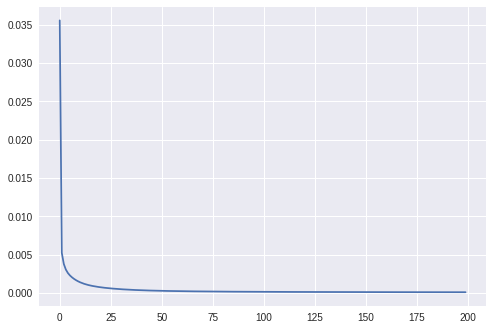

In [8]:
train_imgs, train_labels, mean_img = get_imgs([0,1], True)
test_imgs, test_labels, mean_img = get_imgs([0,1], False, mean_img)
net = NeuralNet(train_imgs, train_labels, test_imgs, test_labels)
L = net.train()
plt.plot(np.arange(net.num_epochs), L)


In [9]:
net.test()

pred:  [1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1]
labels:  [1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0]
correct:  98
pred:  [1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1]
labels:  [1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1]
correct:  99
pred:  [1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1
 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1

Train for 200 of 2 classes, with ```momentum=0.9```

Epoch:  5  Loss:  0.002644433165211141
Epoch:  10  Loss:  0.0015455695695835295
Epoch:  15  Loss:  0.0010565992459097735
Epoch:  20  Loss:  0.0007962832823789123
Epoch:  25  Loss:  0.000631626824557879
Epoch:  30  Loss:  0.0005159314617816853
Epoch:  35  Loss:  0.0004311038985248896
Epoch:  40  Loss:  0.0003680409637172928
Epoch:  45  Loss:  0.0003205961505516114
Epoch:  50  Loss:  0.00028427290309453716
Epoch:  55  Loss:  0.00025588896010212477
Epoch:  60  Loss:  0.0002332537308519374
Epoch:  65  Loss:  0.00021486451906243956
Epoch:  70  Loss:  0.00019967822365181946
Epoch:  75  Loss:  0.00018695717304280444
Epoch:  80  Loss:  0.00017616886079493057
Epoch:  85  Loss:  0.00016692103418496058
Epoch:  90  Loss:  0.00015891923126103814
Epoch:  95  Loss:  0.00015193853460824413
Epoch:  100  Loss:  0.00014580442333241174
Epoch:  105  Loss:  0.0001403795419792091
Epoch:  110  Loss:  0.0001355543878851085
Epoch:  115  Loss:  0.00013124064179254603
Epoch:  120  Loss:  0.00012736631379552175
Ep

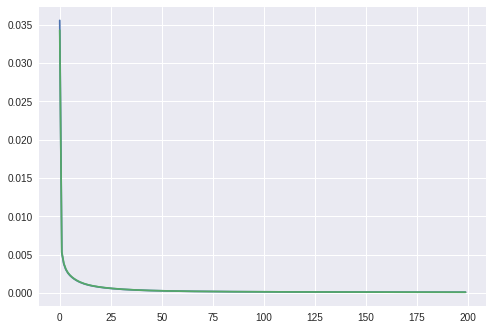

In [10]:
train_imgs, train_labels, mean_img = get_imgs([0,1],True)
test_imgs, test_labels, mean_img = get_imgs([0,1],False, mean_img)
net = NeuralNet(train_imgs, train_labels, test_imgs, test_labels)
L1 = net.train()
plt.plot(np.arange(net.num_epochs), L)
plt.plot(np.arange(net.num_epochs), L1)

net.test()

We can see that there's not much difference between SGD and SGD with momentum in this case.

Train for 200 classes of the first 3 classes, with ```momentum=0.9```

Epoch:  5  Loss:  0.03994075689352511
Epoch:  10  Loss:  0.03207027984772612
Epoch:  15  Loss:  0.028772601438246517
Epoch:  20  Loss:  0.02643187699801569
Epoch:  25  Loss:  0.024334115298744928
Epoch:  30  Loss:  0.02252943992869757
Epoch:  35  Loss:  0.021052611752770393
Epoch:  40  Loss:  0.019815847604027433
Epoch:  45  Loss:  0.018727706103550477
Epoch:  50  Loss:  0.01772323201383323
Epoch:  55  Loss:  0.016775066114894176
Epoch:  60  Loss:  0.015885624398709337
Epoch:  65  Loss:  0.015057965070604376
Epoch:  70  Loss:  0.014285682328313823
Epoch:  75  Loss:  0.013558993243661287
Epoch:  80  Loss:  0.012871163381075499
Epoch:  85  Loss:  0.012220423658054378
Epoch:  90  Loss:  0.011608588889199078
Epoch:  95  Loss:  0.011037713583759975
Epoch:  100  Loss:  0.010506616559118135
Epoch:  105  Loss:  0.01001097620133281
Epoch:  110  Loss:  0.009546363483484853
Epoch:  115  Loss:  0.009110482130463197
Epoch:  120  Loss:  0.008703493054031675
Epoch:  125  Loss:  0.008326859767132171
E

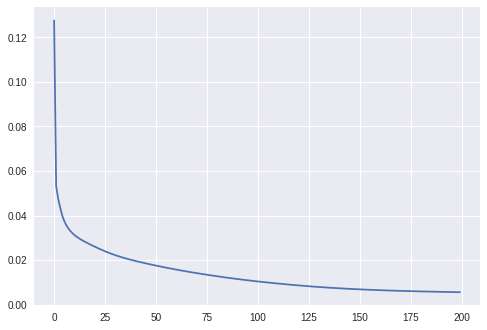

In [13]:
train_imgs, train_labels, mean_img = get_imgs(np.arange(3),True)
test_imgs, test_labels, mean_img = get_imgs(np.arange(3),False, mean_img)
net = NeuralNet(train_imgs, train_labels, test_imgs, test_labels)
L3 = net.train()
plt.plot(np.arange(net.num_epochs), L3)
# plt.plot(np.arange(net.num_epochs), L1)

net.test()

Train for 200 of 4 classes, with ```momentum=0.9```

Epoch:  5  Loss:  0.09394197828339364
Epoch:  10  Loss:  0.08449550431510434
Epoch:  15  Loss:  0.07792734639075018
Epoch:  20  Loss:  0.07372964880731482
Epoch:  25  Loss:  0.0691653719402641
Epoch:  30  Loss:  0.06421491682108661
Epoch:  35  Loss:  0.060117386475116656
Epoch:  40  Loss:  0.05684079039020925
Epoch:  45  Loss:  0.05400566659897317
Epoch:  50  Loss:  0.05135259995592124
Epoch:  55  Loss:  0.04881487906643419
Epoch:  60  Loss:  0.04642754197734574
Epoch:  65  Loss:  0.04422574935527047
Epoch:  70  Loss:  0.04221922596544091
Epoch:  75  Loss:  0.040404034617129915
Epoch:  80  Loss:  0.0387723452611892
Epoch:  85  Loss:  0.03731220816493283
Epoch:  90  Loss:  0.03600040369226133
Epoch:  95  Loss:  0.034812579016558785
Epoch:  100  Loss:  0.03373476654813083
Epoch:  105  Loss:  0.03275692171791073
Epoch:  110  Loss:  0.03186835811215269
Epoch:  115  Loss:  0.031058208559124383
Epoch:  120  Loss:  0.030316499800257992
Epoch:  125  Loss:  0.029634621103331826
Epoch:  130  Los

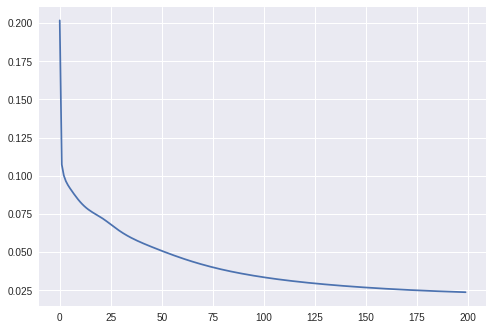

In [12]:
train_imgs, train_labels, mean_img = get_imgs(np.arange(4),True)
test_imgs, test_labels, mean_img = get_imgs(np.arange(4),False, mean_img)
net = NeuralNet(train_imgs, train_labels, test_imgs, test_labels)
L2 = net.train()
plt.plot(np.arange(net.num_epochs), L2)
# plt.plot(np.arange(net.num_epochs), L1)

net.test()